In [1]:
from pathlib import Path

THIS = Path(".")
BASE = THIS / ".."
BASE = BASE.absolute().resolve()

MODEL = BASE / "model"
EXPORTS = BASE / "exports"

MODEL_NAME="Llama-2-7b-hf"

MODEL_PATH = MODEL / MODEL_NAME
EXPORTS = EXPORTS / MODEL_NAME


# Engine

## TGI

In [2]:
METHOD = "engine/tgi"
METHOD_EXPORTS = EXPORTS / METHOD

In [3]:
# print paths
print("BASE:", BASE)
print("MODEL:", MODEL)
print("MODEL_PATH:", MODEL_PATH)
print("METHOD_EXPORTS:", METHOD_EXPORTS)

BASE: /home/shwu/LLM-Efficiency-Survey
MODEL: /home/shwu/LLM-Efficiency-Survey/model
MODEL_PATH: /home/shwu/LLM-Efficiency-Survey/model/Llama-2-7b-hf
METHOD_EXPORTS: /home/shwu/LLM-Efficiency-Survey/exports/Llama-2-7b-hf/engine/tgi


In [4]:

all_models = [x for x in METHOD_EXPORTS.iterdir() if x.is_dir()]
all_models.append(MODEL_PATH)

AWQ_EXPORTS=EXPORTS / "quant/awq"
awq_models = [x for x in AWQ_EXPORTS.iterdir() if x.is_dir()]
all_models.extend(awq_models)


for model in all_models:

    # model_size := size of output.safetensors or <model>.pt
    model_size = sum([x.stat().st_size for x in model.glob("*.safetensors")])
    print(f"{model.name}: {model_size / (1024 ** 3):.2f} GiB")

gptq: 3.69 GiB
Llama-2-7b-hf: 0.00 GiB
q4_gemv: 3.62 GiB
q4_gemm: 3.62 GiB


In [5]:
# start scripts
import os
os.makedirs(METHOD_EXPORTS, exist_ok=True)
quant_methods = set([
    "awq",
    "eetq",
    "gptq",
    "bitsandbytes",
    "bitsandbytes-nf4",
    "bitsandbytes-fp4"
])
cmds = []
for model in all_models:
    if "awq" not in str(model) and "gptq" not in str(model):
        cmds.append(f"nvidia-smi --format=csv,nounits --query-gpu=utilization.gpu,utilization.memory,memory.used,memory.free,memory.total -lms 100 > {METHOD_EXPORTS}/gpu_bench_mem_usage_{model.name}.csv &")
        cmds.append(f"text-generation-launcher --model-id {model} 2>&1 | tee {METHOD_EXPORTS}/benchmark_{model.name}.log")

        for method in quant_methods:
            if method != "awq" and method != "gptq":
                cmds.append(f"nvidia-smi --format=csv,nounits --query-gpu=utilization.gpu,utilization.memory,memory.used,memory.free,memory.total -lms 100 > {str(METHOD_EXPORTS.absolute())}/gpu_bench_mem_usage_{method}.csv &")
                cmds.append(f"text-generation-launcher --model-id {model} --quantize {method} 2>&1 | tee {METHOD_EXPORTS}/benchmark_{model.name}_{method}.log")
    else:
        if "awq" in str(model):
            method = "awq"
        elif "gptq" in str(model):
            method = "gptq"
        else:
            raise ValueError("This should not happen")
        cmds.append(f"nvidia-smi --format=csv,nounits --query-gpu=utilization.gpu,utilization.memory,memory.used,memory.free,memory.total -lms 100 > {METHOD_EXPORTS}/gpu_bench_mem_usage_{model.name}.csv &")
        cmds.append(f"text-generation-launcher --model-id {model} --quantize {method} 2>&1 | tee {METHOD_EXPORTS}/benchmark_{method}_{model.name}.log")

        

for cmd_log, cmd_start in zip(cmds[::2], cmds[1::2]):
    print(cmd_log)
    print(cmd_start)
    print()

nvidia-smi --format=csv,nounits --query-gpu=utilization.gpu,utilization.memory,memory.used,memory.free,memory.total -lms 100 > /home/shwu/LLM-Efficiency-Survey/exports/Llama-2-7b-hf/engine/tgi/gpu_bench_mem_usage_gptq.csv &
text-generation-launcher --model-id /home/shwu/LLM-Efficiency-Survey/exports/Llama-2-7b-hf/engine/tgi/gptq --quantize gptq 2>&1 | tee /home/shwu/LLM-Efficiency-Survey/exports/Llama-2-7b-hf/engine/tgi/benchmark_gptq_gptq.log

nvidia-smi --format=csv,nounits --query-gpu=utilization.gpu,utilization.memory,memory.used,memory.free,memory.total -lms 100 > /home/shwu/LLM-Efficiency-Survey/exports/Llama-2-7b-hf/engine/tgi/gpu_bench_mem_usage_Llama-2-7b-hf.csv &
text-generation-launcher --model-id /home/shwu/LLM-Efficiency-Survey/model/Llama-2-7b-hf 2>&1 | tee /home/shwu/LLM-Efficiency-Survey/exports/Llama-2-7b-hf/engine/tgi/benchmark_Llama-2-7b-hf.log

nvidia-smi --format=csv,nounits --query-gpu=utilization.gpu,utilization.memory,memory.used,memory.free,memory.total -lms 10

In [13]:
# bench
import time
import requests
import json
import os

url = "http://127.0.0.1:3000/generate"
headers = {
    "Content-Type": "application/json"
}

data = {
    "inputs": "What is the meaning of life?",
    "parameters": {
        "max_new_tokens": 128
    }
}

logs = []

for cmd_log, cmd_start in zip(cmds[::2], cmds[1::2]):
    print(cmd_log)
    print(cmd_start)
    input("Press Enter to continue...")

    trials = []

    for _ in range(10):
        tick = time.time()
        response = requests.post(url, json=data, headers=headers)
        tock = time.time()
        response = response.json()
        trials.append(tock - tick)
    os.system("killall text-generation-launcher")
    os.system("killall nvidia-smi")

    print(f"mean: {sum(trials) / len(trials):.2f} seconds")
    print(f"fastest request took {min(trials)} seconds ({128 / min(trials):.2f} tokens/s)")

    logs.append({
        "cmd_log": cmd_log,
        "cmd_start": cmd_start,
        "trials": trials,
        "response": response
    })


nvidia-smi --format=csv,nounits --query-gpu=utilization.gpu,utilization.memory,memory.used,memory.free,memory.total -lms 100 > /home/shwu/LLM-Efficiency-Survey/exports/Llama-2-7b-hf/engine/tgi/gpu_bench_mem_usage_gptq.csv &
text-generation-launcher --model-id /home/shwu/LLM-Efficiency-Survey/exports/Llama-2-7b-hf/engine/tgi/gptq --quantize gptq 2>&1 | tee /home/shwu/LLM-Efficiency-Survey/exports/Llama-2-7b-hf/engine/tgi/benchmark_gptq_gptq.log
mean: 3.72 seconds
fastest request took 3.671558380126953 seconds (34.86 tokens/s)
nvidia-smi --format=csv,nounits --query-gpu=utilization.gpu,utilization.memory,memory.used,memory.free,memory.total -lms 100 > /home/shwu/LLM-Efficiency-Survey/exports/Llama-2-7b-hf/engine/tgi/gpu_bench_mem_usage_Llama-2-7b-hf.csv &
text-generation-launcher --model-id /home/shwu/LLM-Efficiency-Survey/model/Llama-2-7b-hf 2>&1 | tee /home/shwu/LLM-Efficiency-Survey/exports/Llama-2-7b-hf/engine/tgi/benchmark_Llama-2-7b-hf.log
mean: 3.79 seconds
fastest request took 3.

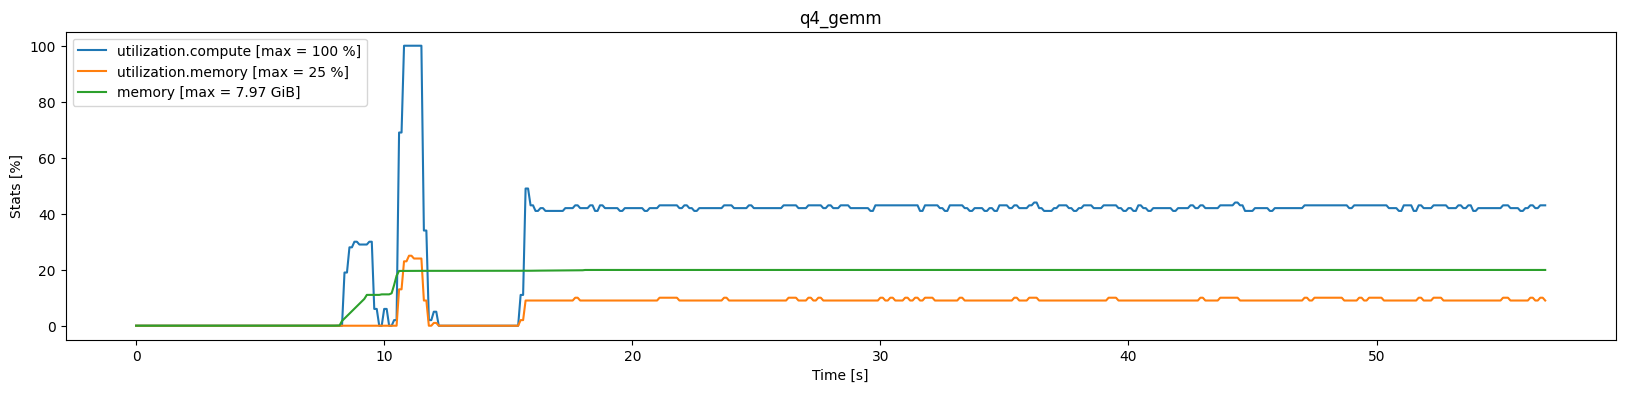

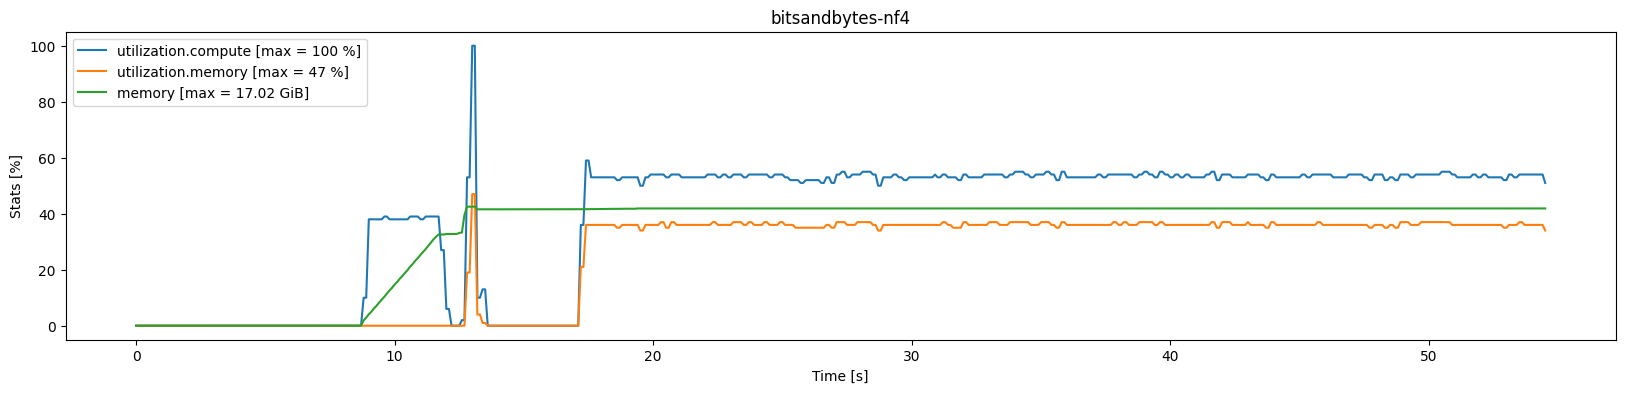

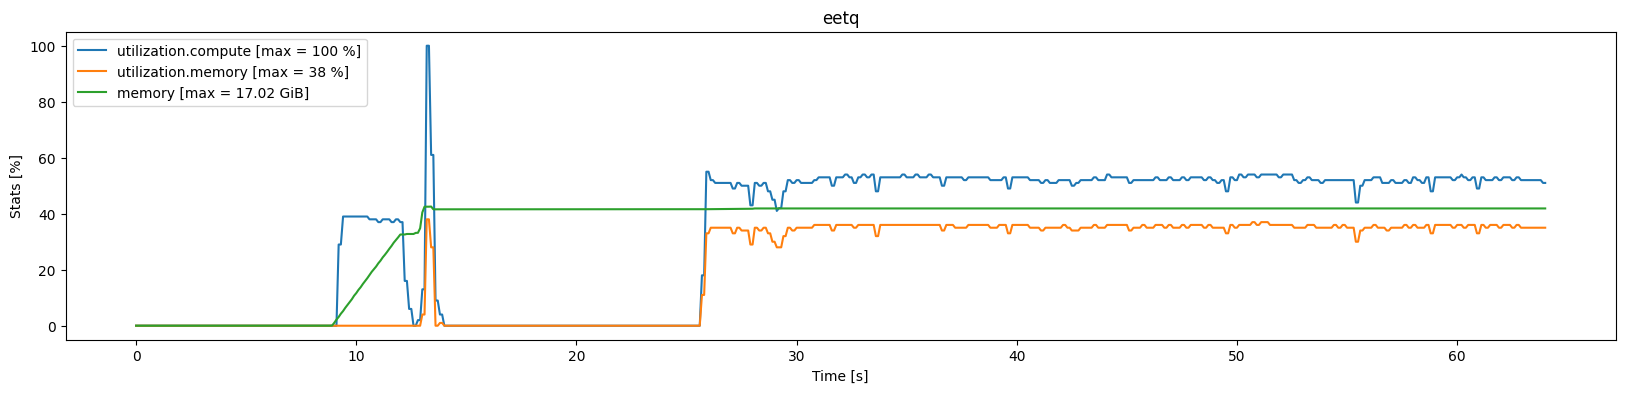

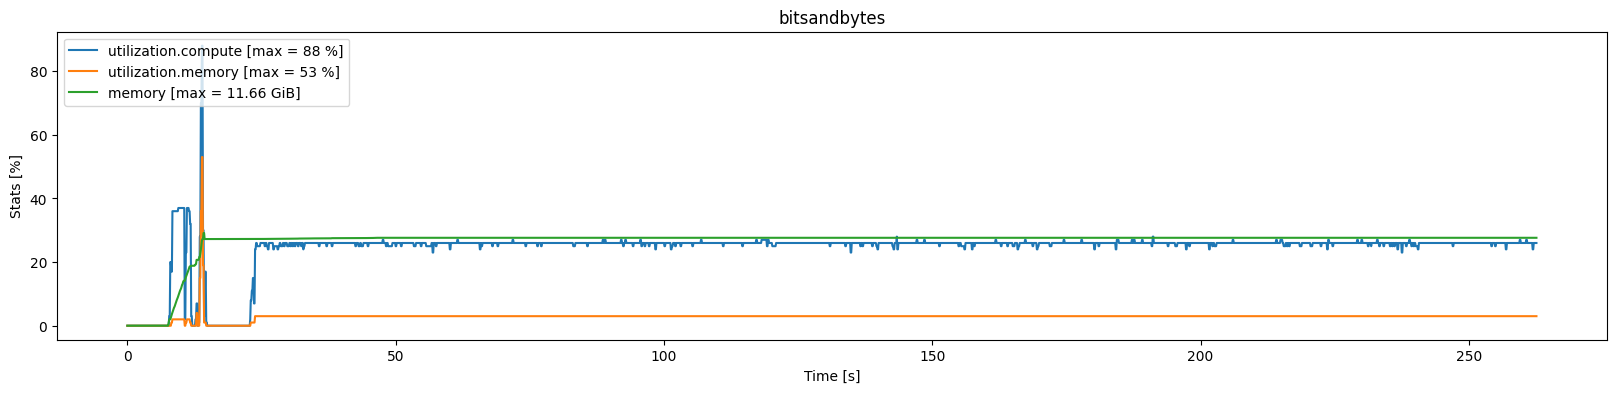

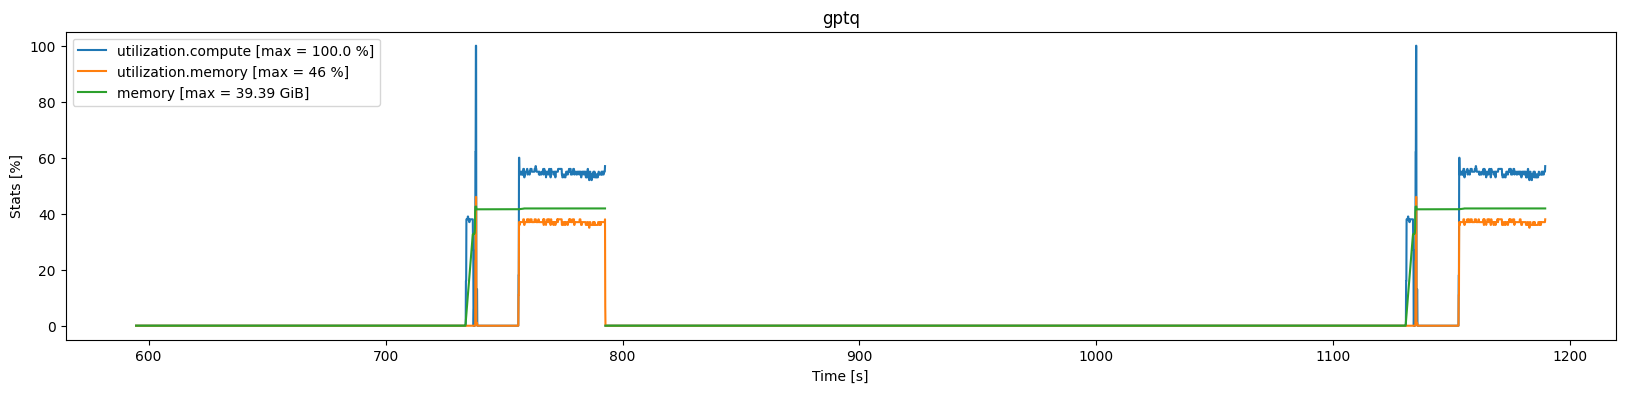

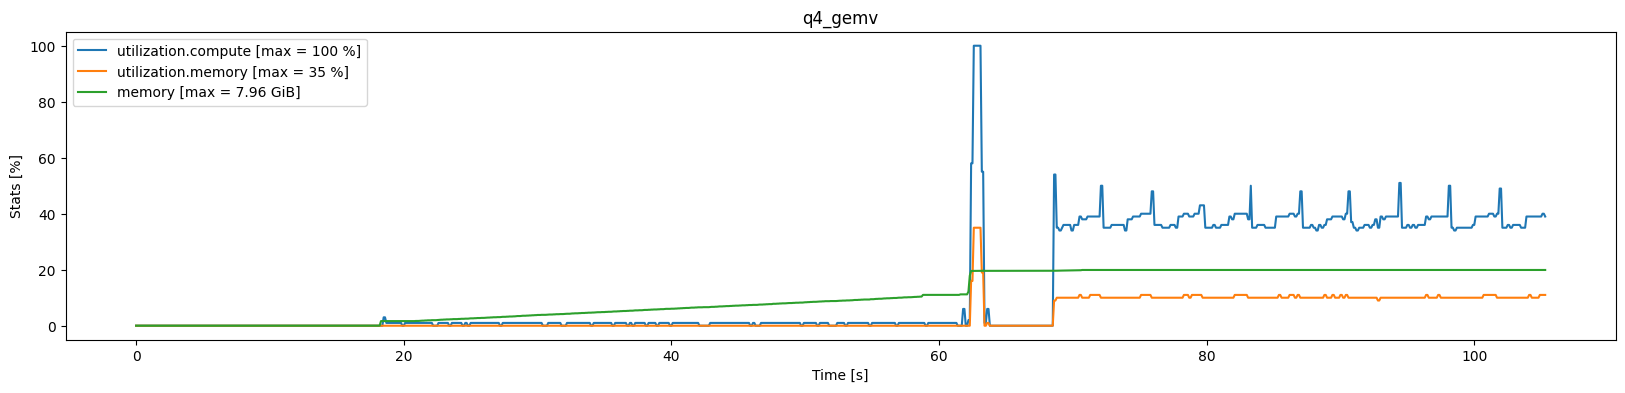

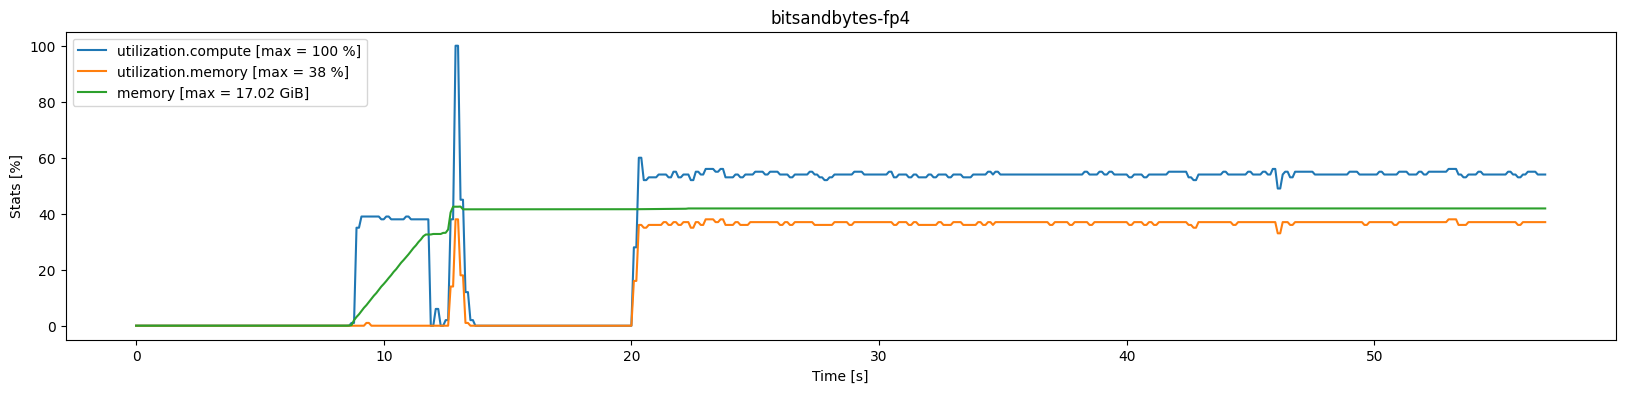

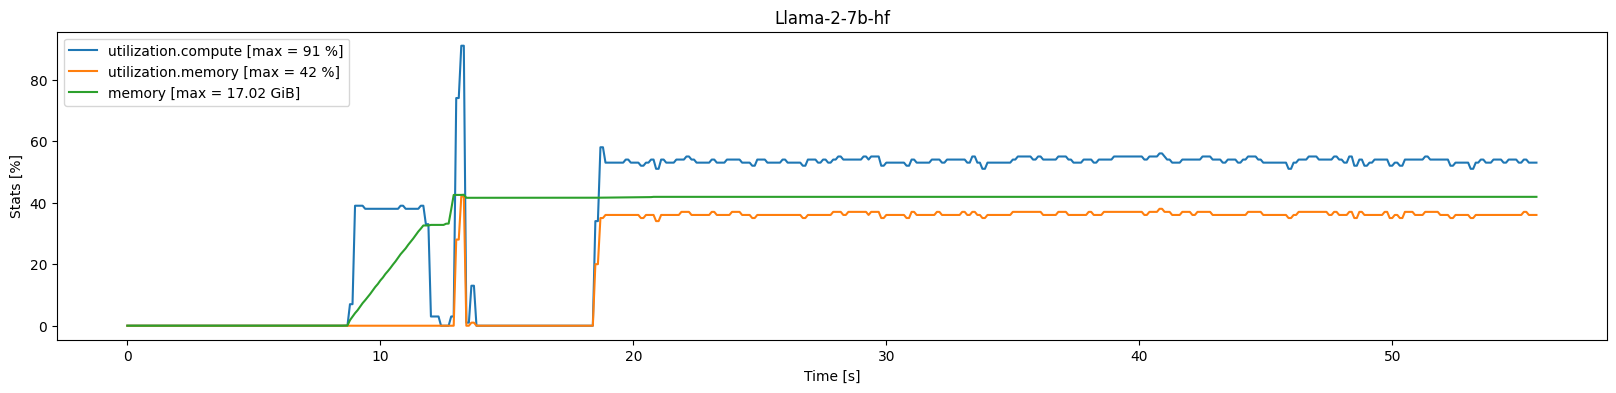

In [5]:
# max mem usage
import pandas as pd
import matplotlib.pyplot as plt
all_csvs = list(METHOD_EXPORTS.glob("*.csv"))

# csv header
# utilization.gpu [%], utilization.memory [%], memory.used [MiB], memory.free [MiB], memory.total [MiB]
utlization_gpu_key = "utilization.gpu [%]"
utilization_memory_key = " " + "utilization.memory [%]"
memory_used_key = " " + "memory.used [MiB]"
memory_free_key = " " + "memory.free [MiB]"
memory_total_key = " " + "memory.total [MiB]"

for csv in all_csvs:
    if not "bench" in csv.name:
        continue
    df = pd.read_csv(csv)

    if "gptq" in csv.name: # gptq takes a lot of time to load, avoid the stale values in graph
        df = df[len(df) // 2:]


    # plot csv of utilization.memory [%] and utilization.gpu [%] both on y-axis

    fig, ax1 = plt.subplots(figsize=(20, 4))
    plt.title(csv.name.split('usage')[-1][1:-4])
    ax1.set_ylabel("Stats [%]")
    ax1.set_xlabel("Time [s]")
    ax1.plot(df.index * 0.1, df[utlization_gpu_key], label=f"utilization.compute [max = {df[utlization_gpu_key].max()} %]")
    ax1.plot(df.index * 0.1, df[utilization_memory_key], label=f"utilization.memory [max = {df[utilization_memory_key].max()} %]")
    ax1.plot(df.index * 0.1, (df[memory_used_key] / df[memory_total_key]) * 100, label=f"memory [max = {df[memory_used_key].max() / 1024:.2f} GiB]")
    ax1.legend(loc="upper left")

In [17]:
import json
with open(METHOD_EXPORTS / "logs.json", "w") as f:
    json.dump(logs, f)

In [19]:
del logs

In [11]:
# bench eetq

# cmd_log = "nvidia-smi --format=csv,nounits --query-gpu=utilization.gpu,utilization.memory,memory.used,memory.free,memory.total -lms 100 > /home/shwu/LLM-Efficiency-Survey/exports/Llama-2-7b-hf/engine/tgi/gpu_bench_mem_usage_eetq.csv &"
# cmd_start = "text-generation-launcher --model-id /home/shwu/LLM-Efficiency-Survey/model/Llama-2-7b-hf --quantize eetq 2>&1 | tee /home/shwu/LLM-Efficiency-Survey/exports/Llama-2-7b-hf/engine/tgi/benchmark_Llama-2-7b-hf_eetq.log"
# print(cmd_log + cmd_start)
import time
import requests
import json
import os

url = "http://127.0.0.1:3000/generate"
headers = {
    "Content-Type": "application/json"
}

data = {
    "inputs": "What is the meaning of life?",
    "parameters": {
        "max_new_tokens": 128
    }
}

logs = []

trials = []

for _ in range(10):
    tick = time.time()
    response = requests.post(url, json=data, headers=headers)
    tock = time.time()
    response = response.json()
    trials.append(tock - tick)
os.system("killall text-generation-launcher")
os.system("killall nvidia-smi")

print(f"mean: {sum(trials) / len(trials):.2f} seconds")
print(f"fastest request took {min(trials)} seconds ({128 / min(trials):.2f} tokens/s)")

logs.append({
    "cmd_log": cmd_log,
    "cmd_start": cmd_start,
    "trials": trials,
    "response": response
})


mean: 3.91 seconds
fastest request took 3.8281493186950684 seconds (33.44 tokens/s)
